# Computer Vision Parking Lot Occupancy
## Video Analysis

## Settings

In [1]:
#!pip install moviepy
#!pip install xlwt
#!pip install azure.cognitiveservices.vision.customvision

In [2]:
import os
import cv2
import matplotlib.pyplot as plt
import os.path
import os
import urllib
import datetime
import pandas as pd
import moviepy
from moviepy.editor import *
import xlwt
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
import time
import random
import seaborn as sns
from msrest.authentication import ApiKeyCredentials

In [3]:
import sys
print("You are using Python:", sys.version)

You are using Python: 3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [4]:
print("Today:", datetime.datetime.now())

Today: 2022-01-31 14:21:10.807739


In [5]:
print("Current directory is:\n", os.getcwd())

Current directory is:
 /mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/Parking


In [6]:
import azureml.core
print("Version Azure ML :", azureml.core.VERSION)

Version Azure ML : 1.36.0


In [7]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['Platform']=platform.system()
        info['Platform-release']=platform.release()
        info['Platform-version']=platform.version()
        info['Architecture']=platform.machine()
        info['Hostname']=socket.gethostname()
        info['IP-address']=socket.gethostbyname(socket.gethostname())
        info['MAC-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['Processeur']=platform.processor()
        info['RAM']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" Go"
        return json.dumps(info)
    
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'Platform': 'Linux',
 'Platform-release': '5.4.0-1063-azure',
 'Platform-version': '#66~18.04.1-Ubuntu SMP Thu Oct 21 09:59:28 UTC 2021',
 'Architecture': 'x86_64',
 'Hostname': 'seretkow5',
 'IP-address': '127.0.0.1',
 'MAC-address': '8f:9c:7d:a0:e4:f4',
 'Processeur': 'x86_64',
 'RAM': '220 Go'}

In [8]:
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor

In [9]:
print("Disk Information")
print("Partitions and Usage:\n")

# get all disk partitions
partitions = psutil.disk_partitions()
for partition in partitions:
    print(f"=== Device: {partition.device} ===")
    print(f"  Mountpoint: {partition.mountpoint}")
    print(f"  File system type: {partition.fstype}")
    print()
    try:
        partition_usage = psutil.disk_usage(partition.mountpoint)
    except PermissionError:
        continue
    print(f"  Total Size: {get_size(partition_usage.total)}")
    print(f"  Used: {get_size(partition_usage.used)}")
    print(f"  Free: {get_size(partition_usage.free)}")
    print(f"  Percentage: {partition_usage.percent}%")
    print()

disk_io = psutil.disk_io_counters()
print(f"Total read: {get_size(disk_io.read_bytes)}")
print(f"Total write: {get_size(disk_io.write_bytes)}")

Disk Information
Partitions and Usage:

=== Device: /dev/sdb1 ===
  Mountpoint: /
  File system type: ext4

  Total Size: 118.07GB
  Used: 58.17GB
  Free: 59.89GB
  Percentage: 49.3%

=== Device: /dev/sdb15 ===
  Mountpoint: /boot/efi
  File system type: vfat

  Total Size: 104.35MB
  Used: 4.36MB
  Free: 100.00MB
  Percentage: 4.2%

=== Device: /dev/sda1 ===
  Mountpoint: /mnt
  File system type: ext4

  Total Size: 1.38TB
  Used: 61.50GB
  Free: 1.25TB
  Percentage: 4.6%

=== Device: /dev/sda1 ===
  Mountpoint: /tmp
  File system type: ext4

  Total Size: 1.38TB
  Used: 61.50GB
  Free: 1.25TB
  Percentage: 4.6%

Total read: 12.00GB
Total write: 33.25GB


In [10]:
subscription_id = os.environ.get("SUBSCRIPTION_ID", "TOBECOMPLETED")
resource_group = os.environ.get("RESOURCE_GROUP", "TOBECOMPLETED")
workspace_name = os.environ.get("WORKSPACE_NAME", "TOBECOMPLETED")

In [11]:
from azureml.core import Workspace
try:
    ws = Workspace(subscription_id = subscription_id, resource_group = resource_group, workspace_name = workspace_name)
    ws.write_config()
    print("OK")
except:
    print("Error: Workspace not found")

OK


In [12]:
ws = Workspace.from_config()
print('Current Azure ML Workspace: ' + ws.name, 
      'Region: ' + ws.location, 
      'Ressource Group: ' + ws.resource_group, sep='\n')

Current Azure ML Workspace: azuremlvision
Region: westeurope
Ressource Group: azuremlvision-rg


In [13]:
AMLexperiment = 'ParkingLotOccupancy'

In [14]:
from azureml.core import experiment
experiment = Experiment(workspace=ws, name = AMLexperiment)

In [15]:
experiment

Name,Workspace,Report Page,Docs Page
ParkingLotOccupancy,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [16]:
def createdir(dirname):
    # Function to create directory if needed
    import os.path
    from os import path
    if path.os.path.isdir(dirname) :
        print("Directory:", dirname, "exists!\n")
    else:
        print("Creating directory:", dirname)
        os.mkdir(dirname)
        print("Done!\n")

In [17]:
def datetimeformat(ts):
    return datetime.datetime.fromtimestamp(ts)

In [18]:
def nbfiles(mydir):
    for root, _, files in os.walk(mydir):
        print("Directory:", root, "with", len(files), "files.")

## Video analytics

In [19]:
VIDEOFILE = 'video/parking.mp4'

In [67]:
# Viewing the video output
#videoresult = VideoFileClip(VIDEOFILE)
#videoresult.ipython_display(width = 640, height = 480)

In [21]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)

fps = MYVIDEOFILE.fps
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)

print("\033[1;31;34mVideo File :", VIDEOFILE)
print("\n- Width:", w, "\n- Height:", h)
print("- FPS =", round(fps))
print("- Duration in seconds :", duration)
print("- Number of frames =", nbframes)

Video File : video/parking.mp4

- Width: 1100 
- Height: 720
- FPS = 24
- Duration in seconds : 28.29
- Number of frames = 678


## Analysing a video file or a streaming video

> Let's use now the same video but with a different time length. We have an initial long video. **So we will create first a video clip in order to reduce the time**. We will not analyse all the frames (we have a FPS = 30). We can decide to extract only some frames. 

**Some results will be saved into Azure ML experiments.**

In [22]:
# Directories to create if needed
DIR1 = 'results'
DIR2 = 'results/captures'
OUTPUTDIR = 'output'

createdir(DIR1)
createdir(DIR2)
createdir(OUTPUTDIR)

Creating directory: results
Done!

Creating directory: results/captures
Done!

Creating directory: output
Done!



In [23]:
nbfiles(DIR1)

Directory: results with 0 files.
Directory: results/captures with 0 files.


In [24]:
nbfiles(DIR2)

Directory: results/captures with 0 files.


In [25]:
nbfiles(OUTPUTDIR)

Directory: output with 0 files.


### We will create a new videoclip from the initial video

In [26]:
startvideo = 0 # in seconds
endvideo = 25 # in seconds

In [27]:
MYVIDEOFILE = VideoFileClip(VIDEOFILE)
MYCLIP = MYVIDEOFILE.subclip(startvideo, endvideo)

clipduration = MYCLIP.duration # Compute the duration in secs
print("Clip duration =", clipduration, 'seconds')

Clip duration = 25 seconds


In [28]:
# Saving the sample video
MYCLIPNAME = OUTPUTDIR + "/sample.mp4"
MYCLIP.write_videofile(MYCLIPNAME)

Moviepy - Building video output/sample.mp4.
MoviePy - Writing audio in sampleTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video output/sample.mp4



Moviepy - Done !
Moviepy - video ready output/sample.mp4


In [29]:
def datetimeformat(ts):
    return datetime.datetime.fromtimestamp(ts)

for item in os.scandir(OUTPUTDIR):
     print(datetimeformat(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-31 14:21:45.017875 3507556 sample.mp4


## Settings

In [30]:
# Sampling frame (number of extracted frame)
sampling_frames = 1 # so 24 frames for each 1 second (we have here FPS = 24)

# Min confidence in % for object detection ie 20 or 50
minpctprob = 40

# Width & Height of the video
MYVIDEOFILE = VideoFileClip(MYCLIPNAME)
w = MYVIDEOFILE.w
h = MYVIDEOFILE.h

In [31]:
MYVIDEOFILE = VideoFileClip(MYCLIPNAME)

fps = MYVIDEOFILE.fps
duration = MYVIDEOFILE.duration
nbframes = int(fps * duration)
duration_sec = duration
nbprocessedframes = nbframes / sampling_frames
nbframespersec = sampling_frames / fps

print("\033[1;31;34mVideo Clip:", MYCLIPNAME)
print("- Video input size: width =", w, "height =", h)
print("- FPS =", round(fps))
print("- Duration in seconds =", duration_sec)
print("- Number of frames =", nbframes)

print("\nSetting: Min confidence in % =", minpctprob)

print("\nOutput:")
print("- Sampling Frames =", sampling_frames)
print("- Number of frames to analyse =", int(nbprocessedframes))
print("- Video will be processed each", round(nbframespersec, 2), "seconds")

Video Clip: output/sample.mp4
- Video input size: width = 1100 height = 720
- FPS = 24
- Duration in seconds = 25.05
- Number of frames = 601

Setting: Min confidence in % = 40

Output:
- Sampling Frames = 1
- Number of frames to analyse = 601
- Video will be processed each 0.04 seconds


In [32]:
WEBCAM = OUTPUTDIR + "/sample.mp4" # Or you can use a RTSP link to connec to a webcam or a live video camera

if os.path.exists(WEBCAM) == True :
    print("File", WEBCAM, "exists")
    for item in os.scandir(OUTPUTDIR):
         print(datetimeformat(item.stat().st_atime), item.stat().st_size, item.name)

if os.path.exists(WEBCAM) == False :
    print("File", WEBCAM, "did not exist!")

File output/sample.mp4 exists
2022-01-31 14:21:45.017875 3507556 sample.mp4


## Calling the Azure CustomVision deployed model

In [33]:
PREDICTION_KEY = "TOBECOMPLETED"
ENDPOINT = "TOBECOMPLETED"
PROJECT_ID = "TOBECOMPLETED"
ITERATION_NAME = "TOBECOMPLETED"

In [34]:
credentials = ApiKeyCredentials(in_headers={"Prediction-key": PREDICTION_KEY })
predictor = CustomVisionPredictionClient(ENDPOINT, credentials)

## Settings and options

In [35]:
# Parking zones coordinates
zone1_x1 = 43
zone1_x2 = 263
zone1_y1 = zone2_y1 = zone3_y1 = 82
zone1_y2 = zone2_y2 = zone3_y2 = 674
zone2_x1 = 388
zone2_x2 = 617
zone3_x1 = 744
zone3_x2 = 1000

# Color definitions
color_lime = (0, 255, 0)
color_cyan = (255, 255, 0)
color_red = (0, 0, 255)
color_orange = (0, 140, 255)

In [36]:
def callingcvmodel(imagefilename, minconf):
    
    # Info
    print("Analysing:", imagefilename, '\n')
        
    # Reading frame
    global image # Should be passed out of the function
    image = cv2.imread(imagefilename)
  
    with open(imagefilename, mode="rb") as captured_image:
        results = predictor.detect_image(PROJECT_ID, ITERATION_NAME, captured_image)

    # Init
    i = 1 
    nb_vehicles_zone1 = nb_vehicles_zone2 = nb_vehicles_zone3 = nb_vehicles_NA = 0
    location_vehicle = ''

    # Infos msg
    now = str(datetime.datetime.today().strftime ('%d-%b-%Y %H:%M:%S'))
    msg_now = '[CCTV 1] ' + str(now)
    cv2.putText(image, msg_now, (30, 20), cv2.FONT_HERSHEY_PLAIN, 1.1, color_lime, 2, cv2.LINE_AA)

    # Zone displays
    cv2.rectangle(image, (zone1_x1, zone1_y1), (zone1_x2, zone1_y2), color_orange, 4)
    cv2.putText(image, "Area 1", (zone1_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 1.5, color_cyan, 2, cv2.LINE_AA)

    cv2.rectangle(image, (zone2_x1, zone2_y1), (zone2_x2, zone2_y2), color_orange, 4)
    cv2.putText(image, "Area 2", (zone2_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 1.5, color_cyan, 2, cv2.LINE_AA)
        
    cv2.rectangle(image, (zone3_x1, zone3_y1), (zone3_x2, zone3_y2), color_orange, 4)
    cv2.putText(image, "Area 3", (zone3_x1, zone1_y1-10), cv2.FONT_HERSHEY_PLAIN, 1.5, color_cyan, 2, cv2.LINE_AA)

    for prediction in results.predictions:
        if prediction.tag_name == 'Vehicle' and prediction.probability >= minconf:
            # Printing
            bbox = prediction.bounding_box
            print('\033[1;31;34m', i, '\t', str.upper(prediction.tag_name), 
                  '\t', round(prediction.probability, 5))
        
            # Average coordinates of each vehicles
            x_center = int((bbox.width * w) / 2 + (bbox.left  * w))
            y_center = int((bbox.height * h) / 2 + (bbox.top * h))
            
            # Drawing ROI for each vehicles
            cv2.rectangle(image, (int(bbox.left * w), int(bbox.top * h)),
                          (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), color_lime, 2)            
            
            # Testing if vehicles belong to a zone
            if x_center >= zone1_x1 and x_center <= zone1_x2:
                location_vehicle = "zone1"
                nb_vehicles_zone1 += 1
                cv2.rectangle(image, (int(bbox.left * w), int(bbox.top * h)), 
                              (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), color_red, 3)
            
            if x_center >= zone2_x1 and x_center <= zone2_x2:
                location_vehicle = "zone2"
                nb_vehicles_zone2 += 1
                cv2.rectangle(image, (int(bbox.left * w), int(bbox.top * h)), 
                              (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), color_red, 3)
            
            if x_center >= zone3_x1 and x_center <= zone3_x2:
                location_vehicle = "zone3"
                nb_vehicles_zone3 += 1
                cv2.rectangle(image, (int(bbox.left * w), int(bbox.top * h)), 
                              (int((bbox.left + bbox.width) * w), int((bbox.top + bbox.height) * h)), color_red, 3)
            
            if (x_center < zone1_x1) or (x_center > zone1_x2 and x_center < zone2_x1)\
            or (x_center > zone2_x2 and x_center <zone3_x1) or (x_center > zone3_x2):
                location_vehicle = 'Entering/Leaving'
                cv2.putText(image, location_vehicle, (x_center + 25, y_center), 
                            cv2.FONT_HERSHEY_PLAIN, 2, color_lime, 2, cv2.LINE_AA)
                nb_vehicles_NA += 1
                cv2.circle(image, (x_center, y_center), radius=5, color=color_lime, thickness=4)
                cv2.circle(image, (x_center, y_center), radius=10, color=color_red, thickness=4)
            
            i+=1

        nb_vehicles = i - 1

    # Display message on the image
    msg_nb_vehicules = 'Number of vehicles = ' + str(nb_vehicles)
    cv2.putText(image, msg_nb_vehicules, (30, 50), cv2.FONT_HERSHEY_PLAIN, 2, color_lime, 2, cv2.LINE_AA)
    print()
    print('\033[1;31;32mDetected vehicles in the image =', nb_vehicles)

    # Stats
    totalplaces_zone1 = 24
    totalplaces_zone2 = 22
    totalplaces_zone3 = 23
    totalvehicles_in_zones = nb_vehicles_zone1 + nb_vehicles_zone2 + nb_vehicles_zone3
    totalplaces = totalplaces_zone1 + totalplaces_zone2 + totalplaces_zone3
    freeplaces = totalplaces - totalvehicles_in_zones

    msgfree = 'Free parking spaces available =' + str(freeplaces)
    cv2.putText(image, msgfree, (500, 50), cv2.FONT_HERSHEY_PLAIN, 2, color_lime, 2, cv2.LINE_AA)
    msgfree1 = "Free = " + str(totalplaces_zone1 - nb_vehicles_zone1)
    msgfree2 = "Free = " + str(totalplaces_zone2 - nb_vehicles_zone2)
    msgfree3 = "Free = " + str(totalplaces_zone3 - nb_vehicles_zone3)
        
    # Displaying stats on image
    cv2.putText(image, msgfree1, (zone1_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
                color_cyan, 2, cv2.LINE_AA)
    cv2.putText(image, msgfree2, (zone2_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
                color_cyan, 2, cv2.LINE_AA)
    cv2.putText(image, msgfree3, (zone3_x1 + 100, zone1_y1 - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, 
                color_cyan, 2, cv2.LINE_AA)
        
    # Stats
    free_zone1 = totalplaces_zone1 - nb_vehicles_zone1
    free_zone2 = totalplaces_zone2 - nb_vehicles_zone2
    free_zone3 = totalplaces_zone3 - nb_vehicles_zone3
    nb_parked_vehicles = nb_vehicles - nb_vehicles_NA

    # Printing stats
    print("\033[1;31;91m\nParking spaces available =", freeplaces)
    print("\033[1;31;91m\nNumber of parked vehicles =", nb_parked_vehicles)
    print("\033[1;31;91mNumber of vehicles in zone 1 =", nb_vehicles_zone1, 
          "| Free parking spaces available =", free_zone1)
    print("\033[1;31;91mNumber of vehicles in zone 2 =", nb_vehicles_zone2, 
          "| Free parking spaces available =", free_zone2)
    print("\033[1;31;91mNumber of vehicles in zone 3 =", nb_vehicles_zone3, 
          "| Free parking spaces available =", free_zone3)
    print("\033[1;31;91m\nNumber of vehicules who are entering/leaving = ", nb_vehicles_NA)
    print()

    return now, nb_parked_vehicles, freeplaces, nb_vehicles_NA

In [37]:
callingcvmodel('image/test1.jpg', 0.90)

Analysing: image/test1.jpg 

 1 	 VEHICLE 	 0.99995
 2 	 VEHICLE 	 0.99994
 3 	 VEHICLE 	 0.99993
 4 	 VEHICLE 	 0.99992
 5 	 VEHICLE 	 0.99991
 6 	 VEHICLE 	 0.99991
 7 	 VEHICLE 	 0.99991
 8 	 VEHICLE 	 0.9999
 9 	 VEHICLE 	 0.99989
 10 	 VEHICLE 	 0.99988
 11 	 VEHICLE 	 0.99988
 12 	 VEHICLE 	 0.99988
 13 	 VEHICLE 	 0.99988
 14 	 VEHICLE 	 0.99985
 15 	 VEHICLE 	 0.99985
 16 	 VEHICLE 	 0.99985
 17 	 VEHICLE 	 0.99983
 18 	 VEHICLE 	 0.99982
 19 	 VEHICLE 	 0.9998
 20 	 VEHICLE 	 0.9998
 21 	 VEHICLE 	 0.99978
 22 	 VEHICLE 	 0.99978
 23 	 VEHICLE 	 0.99977
 24 	 VEHICLE 	 0.99977
 25 	 VEHICLE 	 0.99975
 26 	 VEHICLE 	 0.99975
 27 	 VEHICLE 	 0.99974
 28 	 VEHICLE 	 0.99973
 29 	 VEHICLE 	 0.99973
 30 	 VEHICLE 	 0.99971
 31 	 VEHICLE 	 0.99971
 32 	 VEHICLE 	 0.99966
 33 	 VEHICLE 	 0.99965
 34 	 VEHICLE 	 0.99964
 35 	 VEHICLE 	 0.99963
 36 	 VEHICLE 	 0.99961
 37 	 VEHICLE 	 0.9996
 38 	 VEHICLE 	 0.99958
 39 	 VEHICLE 	 0.99957
 40 	 VEHICLE 	 0.9995
 41 	 VEHICLE 	 0.9994
 4

('31-Jan-2022 14:22:06', 54, 15, 1)

## Reading the video or a Webcam RTSP link and applying the CV model on the frames

In [38]:
# Input file or RTSP to analyse
WEBCAM

'output/sample.mp4'

In [39]:
# Min confidence value for the CV model
minconfidence = 0.90

In [40]:
experiment

Name,Workspace,Report Page,Docs Page
ParkingLotOccupancy,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [41]:
# Starting to log values into Azure ML
run = experiment.start_logging(snapshot_directory = None)

In [42]:
cam = cv2.VideoCapture(WEBCAM)

framenumber = 1
print('\033[1;31;34mProcessing the video: ', WEBCAM, 'for every', sampling_frames, "frame(s)", '\n')

if cam.isOpened():
    while True:
        ret, frame = cam.read()
        
        if ret:
            
            t1 = datetime.datetime.now() # Current datetime
            
            if framenumber%sampling_frames == 0: # sampling frames
                # Just to have the same length for the filenames
                if len(str(framenumber)) == 1:
                    framenumberstr = '00000000' + str(framenumber)
                if len(str(framenumber)) == 2:
                    framenumberstr = '0000000' + str(framenumber)
                if len(str(framenumber)) == 3:
                    framenumberstr = '000000' + str(framenumber)
                if len(str(framenumber)) == 4:
                    framenumberstr = '00000' + str(framenumber)
                if len(str(framenumber)) == 5:
                    framenumberstr = '0000' + str(framenumber)
                if len(str(framenumber)) == 6:
                    framenumberstr = '000' + str(framenumber)
                if len(str(framenumber)) == 7:
                    framenumberstr = '00' + str(framenumber)
                if len(str(framenumber)) == 8:
                    framenumberstr = '0' + str(framenumber)
        
                print('\033[1;31;34m', "\nProcessing frame:", framenumberstr, '/', nbframes)
                print("Remaining frames:", nbframes - framenumber, ' | Percent:', 
                      round((nbframes - framenumber) / nbframes, 2) * 100, '\n')
                
                # Saving captured frame
                capturedframe = 'results/captures/frame_' + framenumberstr + '.jpg'    
                cv2.imwrite(capturedframe, frame)
                
                # Calling the model on the captured frame and saving results into Azure ML
                metrics = callingcvmodel(capturedframe, minconfidence)
                run.log('Date', metrics[0])
                #run.log('Frame', framenumberstr)
                run.log('Number_of_parked_vehicles', metrics[1])
                run.log('Spaces_available', metrics[2])
                run.log('Entering_or_leaving', metrics[3])
                
                # Saving results
                outputframe = 'results/processed_frame_' + str(framenumberstr) + '.jpg'
                cv2.imwrite(outputframe, image, [int(cv2.IMWRITE_JPEG_QUALITY), 100] )
        
        if framenumber == nbprocessedframes:
            run.complete() #Stop Azure ML experiment
            print('\n', '\033[1;31;34m', "-" * 20, "End of job", "-" * 20)
            print(datetime.datetime.now(), 'Done in', datetime.datetime.now() - t1, '\n')
            exit # End of process
        
        framenumber += 1

exit
cam.release()


Processing the video:  output/sample.mp4 for every 1 frame(s) 

 
Processing frame: 000000001 / 601
Remaining frames: 600  | Percent: 100.0 

Analysing: results/captures/frame_000000001.jpg 

 1 	 VEHICLE 	 0.9999
 2 	 VEHICLE 	 0.99988
 3 	 VEHICLE 	 0.99985
 4 	 VEHICLE 	 0.9998
 5 	 VEHICLE 	 0.9998
 6 	 VEHICLE 	 0.99979
 7 	 VEHICLE 	 0.99978
 8 	 VEHICLE 	 0.99977
 9 	 VEHICLE 	 0.99977
 10 	 VEHICLE 	 0.99976
 11 	 VEHICLE 	 0.99975
 12 	 VEHICLE 	 0.99974
 13 	 VEHICLE 	 0.99974
 14 	 VEHICLE 	 0.99972
 15 	 VEHICLE 	 0.99971
 16 	 VEHICLE 	 0.9997
 17 	 VEHICLE 	 0.99969
 18 	 VEHICLE 	 0.99968
 19 	 VEHICLE 	 0.99965
 20 	 VEHICLE 	 0.99962
 21 	 VEHICLE 	 0.99961
 22 	 VEHICLE 	 0.99961
 23 	 VEHICLE 	 0.99955
 24 	 VEHICLE 	 0.99949
 25 	 VEHICLE 	 0.99948
 26 	 VEHICLE 	 0.99948
 27 	 VEHICLE 	 0.99948
 28 	 VEHICLE 	 0.99948
 29 	 VEHICLE 	 0.99943
 30 	 VEHICLE 	 0.99942
 31 	 VEHICLE 	 0.99941
 32 	 VEHICLE 	 0.99934
 33 	 VEHICLE 	 0.99934
 34 	 VEHICLE 	 0.99934
 35 	

KeyboardInterrupt: 

## Reporting

In [43]:
experiment

Name,Workspace,Report Page,Docs Page
ParkingLotOccupancy,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


In [44]:
createdir('reports')

Creating directory: reports
Done!



In [45]:
parkingmetrics= run.get_metrics() # Get Metrics from the Azure ML experiment
df = pd.DataFrame(parkingmetrics) # Convert metrics to a pandas df

In [46]:
df.shape

(600, 4)

In [49]:
df.dtypes

Date                         object
Number_of_parked_vehicles     int64
Spaces_available              int64
Entering_or_leaving           int64
dtype: object

In [50]:
df.head(3)

,Date,Number_of_parked_vehicles,Spaces_available,Entering_or_leaving
0,31-Jan-2022 14:22:30,57,12,1
1,31-Jan-2022 14:22:32,57,12,1
2,31-Jan-2022 14:22:34,57,12,1


In [51]:
df.tail(3)

,Date,Number_of_parked_vehicles,Spaces_available,Entering_or_leaving
597,31-Jan-2022 14:43:28,54,15,1
598,31-Jan-2022 14:43:30,54,15,1
599,31-Jan-2022 14:43:32,54,15,1


In [52]:
df.describe()

,Number_of_parked_vehicles,Spaces_available,Entering_or_leaving
count,600.000000,600.000000,600.000000
mean,54.968333,14.031667,1.625000
std,1.113282,1.113282,0.991302
min,54.000000,11.000000,0.000000
25%,54.000000,13.000000,1.000000
50%,55.000000,14.000000,1.000000
75%,56.000000,15.000000,2.000000
max,58.000000,15.000000,4.000000


In [53]:
print("-" * 20, "Statistics about vehicles in the parking", "-" * 20)
print("\nMinimum:")
print(df[['Number_of_parked_vehicles', 'Spaces_available', 'Entering_or_leaving']].min())
print("\nMaximum:")
print(df[['Number_of_parked_vehicles', 'Spaces_available', 'Entering_or_leaving']].max())
print("\nMean:")
print(df[['Number_of_parked_vehicles', 'Spaces_available', 'Entering_or_leaving']].mean())

-------------------- Statistics about vehicles in the parking --------------------

Minimum:
Number_of_parked_vehicles    54
Spaces_available             11
Entering_or_leaving           0
dtype: int64

Maximum:
Number_of_parked_vehicles    58
Spaces_available             15
Entering_or_leaving           4
dtype: int64

Mean:
Number_of_parked_vehicles    54.968333
Spaces_available             14.031667
Entering_or_leaving           1.625000
dtype: float64


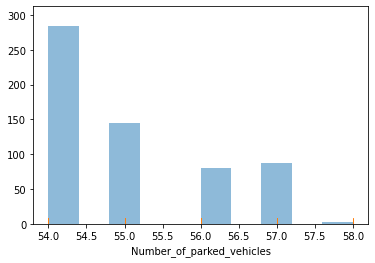

In [54]:
plt.hist(df.Number_of_parked_vehicles, alpha=.5)
sns.rugplot(df.Number_of_parked_vehicles)
plt.show()

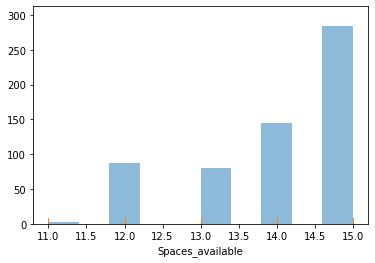

In [55]:
plt.hist(df.Spaces_available, alpha=.5)
sns.rugplot(df.Spaces_available)
plt.show()

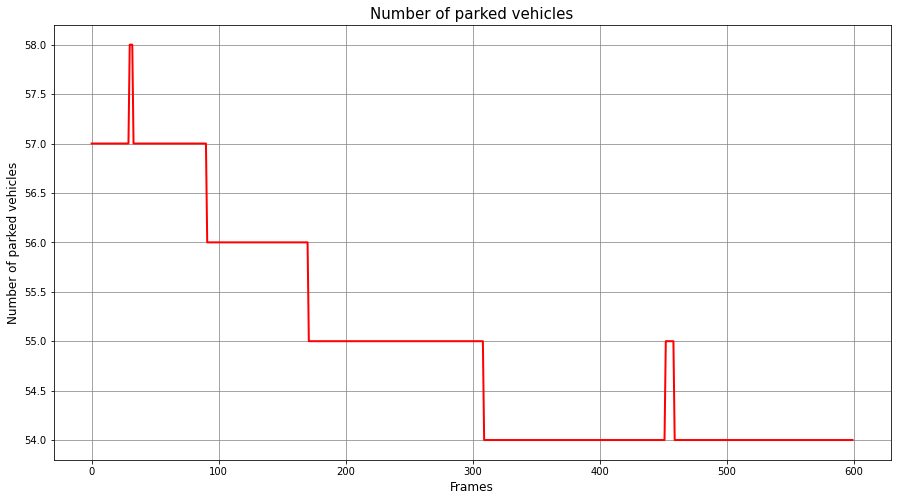

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(df['Number_of_parked_vehicles'], label='Number of parked vehicles', color='red', linewidth = 2)
plt.xlabel('Frames', fontsize = 12)
plt.ylabel('Number of parked vehicles', fontsize = 12)
plt.title('Number of parked vehicles', fontsize = 15)
plt.grid(color='gray', linestyle='-', linewidth = 0.7)
plt.savefig("reports/nb_parked_vehicles.png", dpi=300)
plt.show()

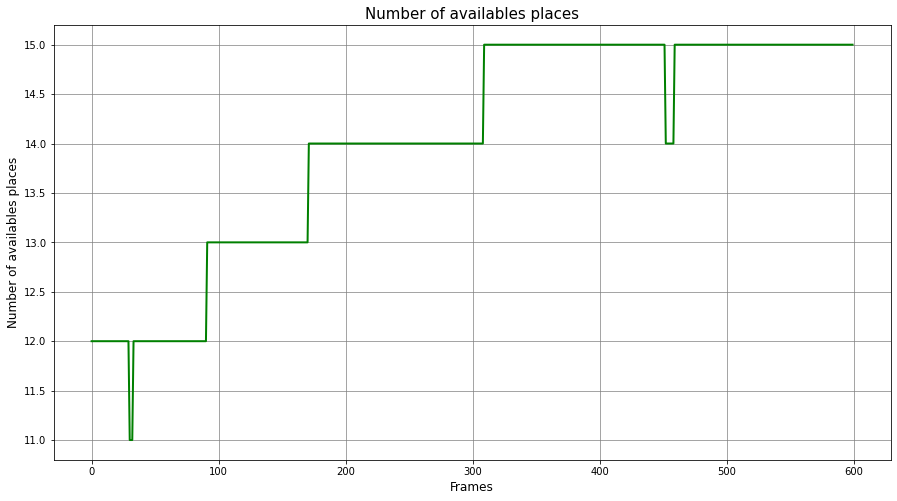

In [57]:
plt.figure(figsize = (15, 8))
plt.plot(df['Spaces_available'], label='Number of availables places', color='green', linewidth = 2)
plt.xlabel('Frames', fontsize = 12)
plt.ylabel('Number of availables places', fontsize = 12)
plt.title('Number of availables places', fontsize = 15)
plt.grid(color='gray', linestyle='-', linewidth = 0.7)
plt.savefig("reports/freeplaces.png", dpi=300)
plt.show()

In [58]:
excelfile = 'reports/parkingmetrics.xls'
df.to_excel(excelfile, sheet_name='Statistics') # Export to Excel

from IPython.display import FileLink
xls_link = FileLink(path = excelfile)
print("Link to download the metrics file:")
xls_link

Link to download the metrics file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/Parking/reports/parkingmetrics.xls

## Saving the processed frames into a new video

In [59]:
results_path = 'results' # input images dir
video_output = 'processed_video_parking.mp4' # Should be an MP4 file

In [60]:
output_path = 'videoresults' # dir to save the video
createdir(output_path) # create the dir

Creating directory: videoresults
Done!



In [61]:
import moviepy.video.io.ImageSequenceClip
image_folder = 'results' # Images to saved into a video file

fps_output = fps # FPS for the video to generate

video_outputfilename = output_path + '/' + video_output # result video file

t1 = datetime.datetime.now()
print(t1, "Building video file:", video_outputfilename, '\n')
image_files = [os.path.join(image_folder, img)
for img in os.listdir(image_folder) if img.endswith(".jpg")]

clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps = fps_output)
print(datetime.datetime.now(), "Writing video file...")
clip.write_videofile(video_outputfilename)

print('\nDone in', datetime.datetime.now() - t1)

2022-01-31 15:08:33.781510 Building video file: videoresults/processed_video_parking.mp4 

2022-01-31 15:09:23.967066 Writing video file...
Moviepy - Building video videoresults/processed_video_parking.mp4.
Moviepy - Writing video videoresults/processed_video_parking.mp4



Moviepy - Done !
Moviepy - video ready videoresults/processed_video_parking.mp4

Done in 0:01:34.770623


In [62]:
# Checking file
for item in os.scandir('videoresults'):
     print(datetimeformat(item.stat().st_atime), item.stat().st_size, item.name)

2022-01-31 15:10:08.532475 4440165 processed_video_parking.mp4


In [1]:
# Viewing the video output
#videoresult = VideoFileClip(video_outputfilename)
#videoresult.ipython_display(width = 640, height = 480)

In [64]:
from IPython.display import FileLink

video_link = FileLink(path = video_outputfilename)
print("Link to download the processed video file:")
video_link

Link to download the processed video file:


/mnt/batch/tasks/shared/LS_root/mounts/clusters/seretkow5/code/Users/seretkow/ComputerVision/Parking/videoresults/processed_video_parking.mp4

In [66]:
experiment

Name,Workspace,Report Page,Docs Page
ParkingLotOccupancy,azuremlvision,Link to Azure Machine Learning studio,Link to Documentation


> End